In [1]:
#https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
#https://keras.io/examples/vision/pointnet/
#https://stackoverflow.com/questions/66845924/multi-input-multi-output-model-with-keras-functional-api

In [1]:
#imports
import os
import sys
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse
from spektral.data.graph import Graph
from keras.models import Model
from keras.layers import Dense, Dropout, Concatenate, Reshape, Add, BatchNormalization, Activation, Conv2D, Conv1D, Input, concatenate
from spektral.layers import GCNConv, GlobalMaxPool, CensNetConv, GATConv, DiffusionConv, ARMAConv, GlobalAvgPool, GINConvBatch, GCSConv
from spektral.data import BatchLoader, DisjointLoader
from spektral.data import Dataset
from spektral.transforms import GCNFilter, NormalizeAdj
from keras.models import Model
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow import keras
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from spektral.data.utils import to_tf_signature, prepend_none
import pickle

In [2]:
#Thingi10k data
#Read data, drop unnecessary
data = pd.read_csv('thingi10k_data.csv', index_col=0)
df = data.copy()
df.drop("source", axis=1, inplace=True)
df.drop("model_name", axis=1, inplace=True)

#Extract build times
dfcopy = df.copy()
build_times = df["build_time"]
df.drop("build_time", axis=1,inplace=True)

#Make pipeline
#https://joaquinamatrodrigo.github.io/skforecast/0.5.1/user_guides/sklearn-transformers-and-pipeline.html

def log_transform(x):
    return np.log(x + 1)

def inv_log_transform(x):
    return np.exp(x) - 1 

#normalizer = Normalizer()
scaler = MinMaxScaler()
logtransformer = FunctionTransformer(func=log_transform, inverse_func=inv_log_transform, check_inverse=False)
pipe = Pipeline(steps=[ ('logtransformer', logtransformer)])

#Train test split
xtrain = df[:3000]
xtest = df[3000:3600]
ytrain = build_times[:3000]
ytest = build_times[3000:3600]

xlabels = xtrain.columns.values

#Fit pipeline
xtrain = pipe.fit_transform(xtrain)
xtrain = pd.DataFrame(xtrain)
xtrain.columns = xlabels

xtest = pipe.transform(xtest)
xtest = pd.DataFrame(xtest)
xtest.columns = xlabels

#Convert to tensors
xtraint = tf.convert_to_tensor(xtrain)
ytraint = tf.convert_to_tensor(ytrain)
xtestt = tf.convert_to_tensor(xtest)
ytestt = tf.convert_to_tensor(ytest)

In [3]:
#Custom batchloader
def getFeatures(batch):
    feats = []
    for graph in batch:
        feats.append(graph.__getattribute__('feats'))
    return np.array(feats)

class MyBatchLoader(BatchLoader):
    def __init__(
        self,
        dataset,
        mask=False,
        batch_size=1,
        epochs=None,
        shuffle=True,
        node_level=False,
    ):
        super().__init__(dataset, mask, batch_size, epochs, shuffle, node_level)

    def __next__(self):
        nxt = self._generator.__next__()
        feats = getFeatures(nxt)
        output, y = self.collate(nxt)
        feats = (feats,)
        output = output + feats
        return   output, y

In [3]:
#Custom disjointloader
def getFeatures(batch):
    feats = []
    for graph in batch:
        feats.append(graph.__getattribute__('feats'))
    return np.array(feats)

class MyDisjointLoader(DisjointLoader):
    def __init__(
        self, dataset, node_level=False, batch_size=1, epochs=None, shuffle=True
    ):
        self.node_level = node_level
        super().__init__(dataset, batch_size=batch_size, epochs=epochs, shuffle=shuffle)

    def __next__(self):
        nxt = self._generator.__next__()
        feats = getFeatures(nxt)
        #feats = nxt[0].__getattribute__('feats')
        output, y = self.collate(nxt)
        feats = (feats,)
        output = output + feats
        return   output, y
    
    def tf_signature(self):
    
        signature = self.dataset.signature
        if "y" in signature:
            signature["y"]["shape"] = prepend_none(signature["y"]["shape"])
        if "a" in signature:
            signature["a"]["spec"] = tf.SparseTensorSpec

        signature["i"] = dict()
        signature["i"]["spec"] = tf.TensorSpec
        signature["i"]["shape"] = (None,)
        signature["i"]["dtype"] = tf.as_dtype(tf.int64)

        sig = (tf.TensorSpec(shape=[None,13]),)
        input = to_tf_signature(signature)
        sig = input[0] + sig
        return (sig, input[1])

In [4]:
features = pd.read_csv('thingi10k_data.csv', index_col=0)

adjpath = '../Data/stl/adjacency_stl_simplified/'
cloudpath = '../Data/stl/nodefeatures_stl_simplified/'
edgepath = '../Data/stl/edgefeaturesmatrix_stl_simplified/'

In [5]:
coords = np.empty((1,3))
targets = np.empty(1)
print(coords.shape)

for i in range(3000):
    if(os.path.isfile(adjpath + f'{features["model_name"][i]}.npz')):
        point_cloud = np.load(cloudpath + f'{features["model_name"][i]}.npy').reshape(-1,3)
        coords = np.concatenate((coords,point_cloud))
        
coords = np.delete(coords,0,0)

centroids = np.mean(coords,0)
coordscentered = coords - centroids
furthest_distance = np.max(np.sqrt(np.sum(coordscentered**2,axis=-1) / 2999))

(1, 3)


In [6]:
#Graph data
build_times = []

class MyDataset(Dataset):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def read(self):
        output = []

        #files = os.listdir("../Data/adjmatrices/")
        #2000 graphs ~ 20 mins per epoch
        for i in range(3000):
            if(os.path.isfile(adjpath + f'{features["model_name"][i]}.npz')):
                adjmatrix = scipy.sparse.load_npz(adjpath + f'{features["model_name"][i]}.npz')
                point_cloud = np.load(cloudpath + f'{features["model_name"][i]}.npy').reshape(-1,3)
                edgefeat = scipy.sparse.load_npz(edgepath + f'{features["model_name"][i]}.npz')
                output.append(
                    Graph(x=((point_cloud - centroids)/furthest_distance), a=edgefeat, y=features["build_time"][i], feats=xtraint[i])
                )

        return output
    
dataset = MyDataset()

class TestDataset(Dataset):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def read(self):
        output = []

        #files = os.listdir("../Data/adjmatrices/")
        for i in range(3000,3600):
            if(os.path.isfile(adjpath + f'{features["model_name"][i]}.npz')):
                adjmatrix = scipy.sparse.load_npz(adjpath + f'{features["model_name"][i]}.npz')
                point_cloud = np.load(cloudpath + f'{features["model_name"][i]}.npy').reshape(-1,3)
                edgefeat = scipy.sparse.load_npz(edgepath + f'{features["model_name"][i]}.npz')
                output.append(
                    Graph(x=((point_cloud - centroids)/furthest_distance), a=edgefeat, y=features["build_time"][i], feats=xtestt[i-3000])
                )

        return output
    
testdataset = TestDataset()
dataset

MyDataset(n_graphs=3000)

In [ ]:
#Preprocessing
dataset.apply(GCNFilter())
testdataset.apply(GCNFilter())

In [7]:
dataset.apply(NormalizeAdj())
testdataset.apply(NormalizeAdj())

In [5]:
dataset[0].__getattribute__('feats')

<tf.Tensor: shape=(13,), dtype=float64, numpy=
array([0.05943416, 0.05045825, 0.57560402, 0.18554009, 0.17833392,
       0.21931037, 0.22637433, 0.37725807, 0.33274221, 0.21853556,
       0.07701223, 0.13074847, 0.1053974 ])>

In [89]:
testloader = MyDisjointLoader(testdataset, batch_size=1)

In [117]:
testloader.load()

<FlatMapDataset element_spec=((TensorSpec(shape=(None, 3), dtype=tf.float64, name=None), SparseTensorSpec(TensorShape([None, None]), tf.float64), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(13,), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [27]:
keras.backend.clear_session()

In [42]:
to_tf_signature(testdataset.signature)

((TensorSpec(shape=(None, 3), dtype=tf.float64, name=None),
  SparseTensorSpec(TensorShape([None, None]), tf.float64)),
 TensorSpec(shape=(1,), dtype=tf.int64, name=None))

In [72]:
batch = testloader.__next__()
batch[0]

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


(array([[ 41.        , 200.        ,   0.        ],
        [ 25.        , 200.        ,   0.        ],
        [ 25.        , 242.        ,   0.        ],
        ...,
        [ 41.        , 228.57106018,  29.91878319],
        [ 41.        , 215.29289246,  38.70710754],
        [ 41.        , 215.13397217,  38.5       ]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       

In [8]:
#NN Model
'''inputs = Input(name='features input', type_spec=tf.TensorSpec(shape=(None, 13)))
x = Dense(104, activation='relu')(inputs)
x = Dense(8, activation='relu')(x)
x = Dense(8, activation='relu')(x)
x = Dense(8, activation='relu')(x)
x = Dense(1, activation='linear')(x)
nnmodel = Model(inputs, x)'''

#nnmodel = keras.models.load_model('savedmodels/Baseline_1000e_normlayer')
nnmodel = keras.models.load_model('savedmodels/Baseline_thesis')

'''for layer in nnmodel.layers:
    layer.trainable = False'''

'for layer in nnmodel.layers:\n    layer.trainable = False'

In [9]:
nnmodel.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 13)               27        
 ion)                                                            
                                                                 
 dense_28 (Dense)            (None, 72)                1008      
                                                                 
 dense_29 (Dense)            (None, 248)               18104     
                                                                 
 dense_30 (Dense)            (None, 8)                 1992      
                                                                 
 dense_31 (Dense)            (None, 1)                 9         
                                                                 
Total params: 21,140
Trainable params: 0
Non-trainable params: 21,140
__________________________________________________

In [9]:
#GCN Model
'''xi = Input(shape=(None,3), name= "input x")
ai = Input(shape=(None,None), name= 'input a')
x = ResBlock(8)([xi,ai])
x = ResBlock(16)([x,ai])
x = ResBlock(32)([x,ai])
x = GlobalAvgPool()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(8)(x)
x = Dropout(0.5)(x)
gcnmodel = Model(inputs=[xi,ai], outputs=x)'''

#gcnmodel = keras.models.load_model('savedmodels/GCN_simplified')
gcnmodel = keras.models.load_model('savedmodels/GCN_simplified_normalized')
'''for layer in gcnmodel.layers:
    layer.trainable = False'''

'for layer in gcnmodel.layers:\n    layer.trainable = False'

In [10]:
gcnmodel.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputx (InputLayer)            [(None, 3)]          0           []                               
                                                                                                  
 inputa (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 gcs_conv_4 (GCSConv)           (None, 64)           448         ['inputx[0][0]',                 
                                                                  'inputa[0][0]']                 
                                                                                                  
 gcs_conv_5 (GCSConv)           (None, 128)          16512       ['gcs_conv_4[0][0]',       

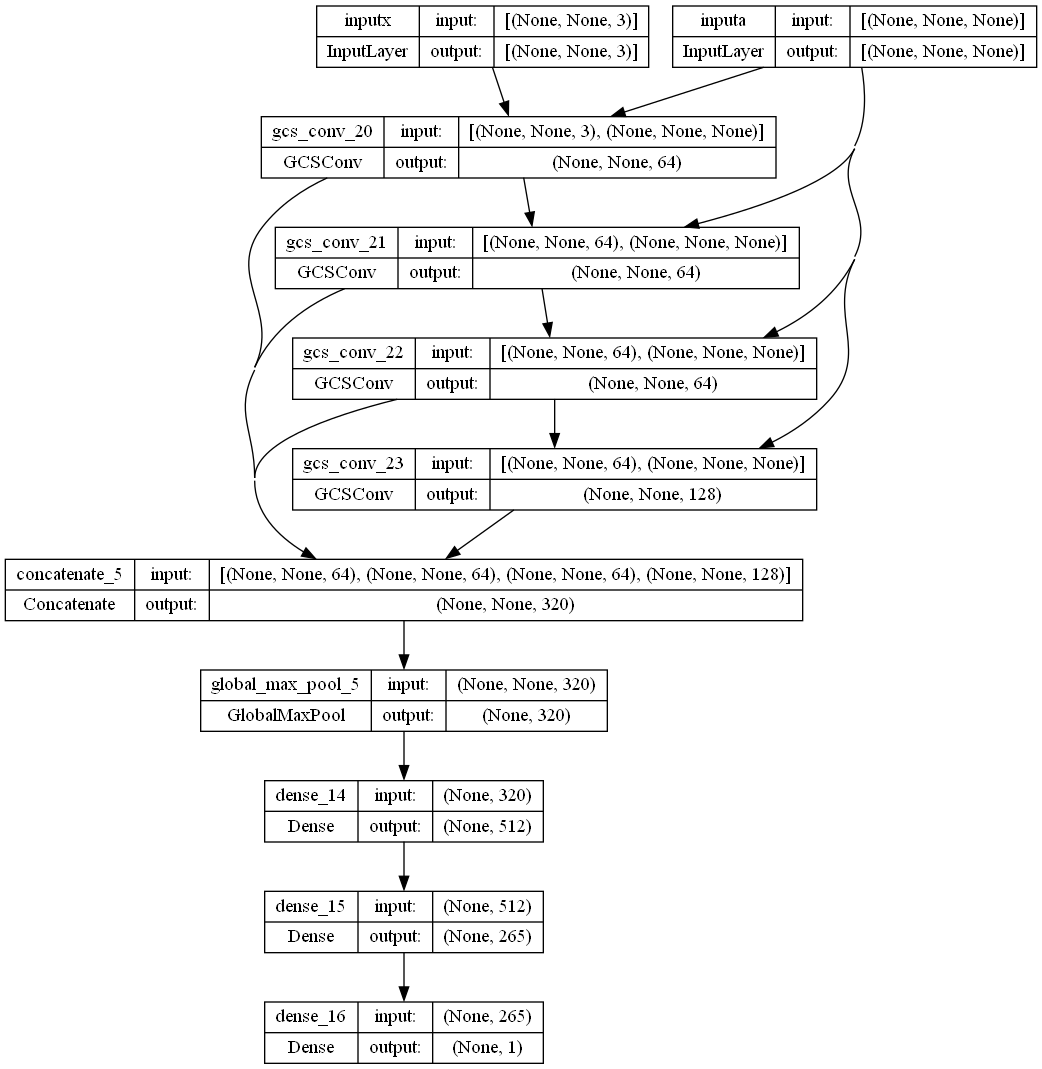

In [12]:
keras.utils.plot_model(gcnmodel, "savedimages/gcnmodel.png", show_shapes=True)

In [27]:
#concatenate
combined = concatenate([nnmodel.get_layer('dense_30').output, gcnmodel.get_layer('dropgcn').output], name='join')
z = Dense(128,'relu', name='dense1')(combined)
z = Dense(64,'relu', name='dense4')(z)
#z = Dropout(0.2, name='finaldrop')(z)
z = Dense(1, 'linear', name='regress')(z)
model = Model(inputs = [gcnmodel.input, nnmodel.input], outputs = z)

In [15]:
model.input

[[<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'inputx')>,
  <KerasTensor: type_spec=SparseTensorSpec(TensorShape([None, None]), tf.float32) (created by layer 'inputa')>,
  <KerasTensor: shape=(None,) dtype=int32 (created by layer 'inputi')>],
 <KerasTensor: shape=(None, 13) dtype=float32 (created by layer 'baselineinput')>]

In [11]:
model.name

'model'

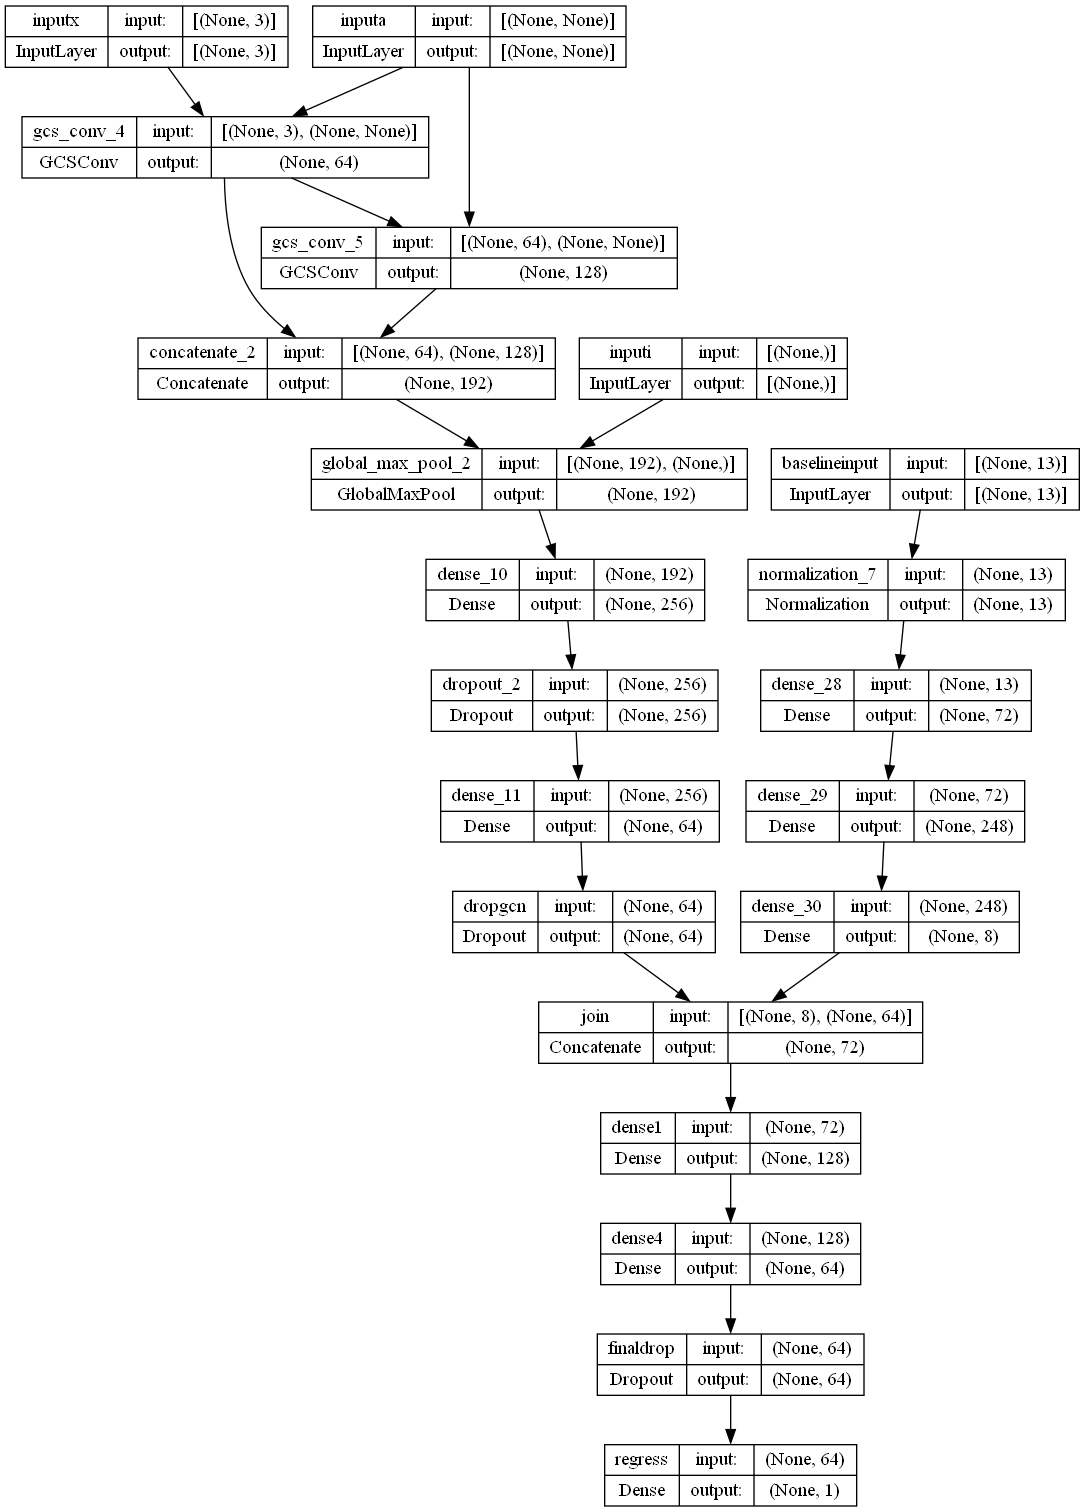

In [16]:
keras.utils.plot_model(model, "savedimages/multi_inputmodel.png", show_shapes=True)

In [12]:
#Define callbacks
def get_callbacks(weights_file, patience, lr_factor):
  return [
      # Only save the weights that correspond to the minimum mape.
      ModelCheckpoint(filepath= weights_file,
                      monitor="val_mape", 
                      mode="min",
                      save_best_only=True, 
                      save_weights_only=False),
      # If val_loss doesn't improve for a number of epochs set with 'patience' var 
      # training will stop to avoid overfitting.    
      EarlyStopping(monitor="val_loss",
                    mode="min",
                    patience = patience,
                    verbose=1),
      # Learning rate is reduced by 'lr_factor' if val_loss stagnates
      # for a number of epochs set with 'patience/2' var.     
      ReduceLROnPlateau(monitor="val_loss", mode="min",
                        factor=lr_factor, min_lr=1e-8, patience=patience//2, verbose=1)]

In [13]:
def get_overfit_callbacks(patience, lr_factor):
  return [
      # Only save the weights that correspond to the minimum mape.
      # If val_loss doesn't improve for a number of epochs set with 'patience' var 
      # training will stop to avoid overfitting.    
      EarlyStopping(monitor="val_loss",
                    mode="min",
                    patience = patience,
                    verbose=1),
      # Learning rate is reduced by 'lr_factor' if val_loss stagnates
      # for a number of epochs set with 'patience/2' var.     
      ReduceLROnPlateau(monitor="val_loss", mode="min",
                        factor=lr_factor, min_lr=1e-8, patience=patience//2, verbose=1)]

In [ ]:
#Reset weights
def reset_weights(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel.initializer'): 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias.initializer'):
            layer.bias.initializer.run(session=session)

reset_weights(model)

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , loss='mape', metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape"), 'mae'])

In [29]:
loader = MyDisjointLoader(dataset, batch_size=32)
testloader = MyDisjointLoader(testdataset, batch_size=32)

In [31]:
history = model.fit(loader.load(), validation_data=testloader.load(), validation_steps=testloader.steps_per_epoch, steps_per_epoch=loader.steps_per_epoch, epochs=1000, verbose=2, callbacks=get_callbacks("Multi_input_reset", patience=60,lr_factor=0.3))

Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


INFO:tensorflow:Assets written to: Multi_input_reset\assets


INFO:tensorflow:Assets written to: Multi_input_reset\assets


94/94 - 10s - loss: 15.7286 - mape: 15.7256 - mae: 60.1567 - val_loss: 8.5540 - val_mape: 8.5522 - val_mae: 37.1646 - lr: 0.0010 - 10s/epoch - 103ms/step
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


94/94 - 8s - loss: 6.1307 - mape: 6.1291 - mae: 22.5865 - val_loss: 8.6571 - val_mape: 8.6554 - val_mae: 34.4276 - lr: 0.0010 - 8s/epoch - 84ms/step
Epoch 3/1000


INFO:tensorflow:Assets written to: Multi_input_reset\assets


INFO:tensorflow:Assets written to: Multi_input_reset\assets


94/94 - 9s - loss: 6.0795 - mape: 6.0779 - mae: 19.4230 - val_loss: 8.3154 - val_mape: 8.3140 - val_mae: 28.2481 - lr: 0.0010 - 9s/epoch - 97ms/step
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


94/94 - 8s - loss: 5.9575 - mape: 5.9560 - mae: 18.6513 - val_loss: 8.3922 - val_mape: 8.3906 - val_mae: 27.8620 - lr: 0.0010 - 8s/epoch - 83ms/step
Epoch 5/1000


INFO:tensorflow:Assets written to: Multi_input_reset\assets


INFO:tensorflow:Assets written to: Multi_input_reset\assets


94/94 - 9s - loss: 5.9477 - mape: 5.9463 - mae: 15.7712 - val_loss: 8.2400 - val_mape: 8.2387 - val_mae: 21.1077 - lr: 0.0010 - 9s/epoch - 96ms/step
Epoch 6/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


94/94 - 8s - loss: 5.8334 - mape: 5.8320 - mae: 12.8615 - val_loss: 8.2659 - val_mape: 8.2645 - val_mae: 20.9264 - lr: 0.0010 - 8s/epoch - 82ms/step
Epoch 7/1000
94/94 - 8s - loss: 6.0189 - mape: 6.0176 - mae: 15.1786 - val_loss: 8.6034 - val_mape: 8.6021 - val_mae: 23.0060 - lr: 0.0010 - 8s/epoch - 81ms/step
Epoch 8/1000


INFO:tensorflow:Assets written to: Multi_input_reset\assets


INFO:tensorflow:Assets written to: Multi_input_reset\assets


94/94 - 9s - loss: 6.0383 - mape: 6.0370 - mae: 13.5391 - val_loss: 8.2170 - val_mape: 8.2156 - val_mae: 18.8608 - lr: 0.0010 - 9s/epoch - 101ms/step
Epoch 9/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


94/94 - 8s - loss: 5.8601 - mape: 5.8587 - mae: 12.5906 - val_loss: 9.0082 - val_mape: 9.0068 - val_mae: 30.7675 - lr: 0.0010 - 8s/epoch - 80ms/step
Epoch 10/1000
94/94 - 7s - loss: 5.9587 - mape: 5.9573 - mae: 11.6036 - val_loss: 8.3019 - val_mape: 8.3004 - val_mae: 18.5274 - lr: 0.0010 - 7s/epoch - 79ms/step
Epoch 11/1000
94/94 - 7s - loss: 6.0126 - mape: 6.0110 - mae: 12.3883 - val_loss: 8.5614 - val_mape: 8.5597 - val_mae: 24.8397 - lr: 0.0010 - 7s/epoch - 78ms/step
Epoch 12/1000
94/94 - 7s - loss: 5.7491 - mape: 5.7476 - mae: 11.3276 - val_loss: 8.2634 - val_mape: 8.2619 - val_mae: 20.2478 - lr: 0.0010 - 7s/epoch - 78ms/step
Epoch 13/1000
94/94 - 7s - loss: 5.8006 - mape: 5.7990 - mae: 11.3565 - val_loss: 8.3378 - val_mape: 8.3363 - val_mae: 19.4466 - lr: 0.0010 - 7s/epoch - 78ms/step
Epoch 14/1000
94/94 - 7s - loss: 5.7494 - mape: 5.7479 - mae: 10.1902 - val_loss: 8.3659 - val_mape: 8.3645 - val_mae: 18.8241 - lr: 0.0010 - 7s/epoch - 77ms/step
Epoch 15/1000
94/94 - 7s - loss: 5.6

INFO:tensorflow:Assets written to: Multi_input_reset\assets


INFO:tensorflow:Assets written to: Multi_input_reset\assets


94/94 - 9s - loss: 5.8291 - mape: 5.8281 - mae: 10.6070 - val_loss: 8.2014 - val_mape: 8.2004 - val_mae: 19.3083 - lr: 0.0010 - 9s/epoch - 91ms/step
Epoch 27/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


94/94 - 7s - loss: 5.9855 - mape: 5.9845 - mae: 11.8705 - val_loss: 8.7012 - val_mape: 8.7002 - val_mae: 22.7571 - lr: 0.0010 - 7s/epoch - 79ms/step
Epoch 28/1000
94/94 - 7s - loss: 5.7501 - mape: 5.7491 - mae: 10.9988 - val_loss: 8.4458 - val_mape: 8.4449 - val_mae: 17.7341 - lr: 0.0010 - 7s/epoch - 77ms/step
Epoch 29/1000
94/94 - 7s - loss: 5.7131 - mape: 5.7120 - mae: 10.1437 - val_loss: 8.3247 - val_mape: 8.3237 - val_mae: 18.2947 - lr: 0.0010 - 7s/epoch - 78ms/step
Epoch 30/1000
94/94 - 7s - loss: 5.6861 - mape: 5.6850 - mae: 10.5728 - val_loss: 8.4971 - val_mape: 8.4960 - val_mae: 23.1755 - lr: 0.0010 - 7s/epoch - 77ms/step
Epoch 31/1000
94/94 - 7s - loss: 5.8379 - mape: 5.8369 - mae: 11.4628 - val_loss: 8.4569 - val_mape: 8.4559 - val_mae: 22.0303 - lr: 0.0010 - 7s/epoch - 79ms/step
Epoch 32/1000
94/94 - 7s - loss: 5.7632 - mape: 5.7623 - mae: 10.7587 - val_loss: 8.6836 - val_mape: 8.6826 - val_mae: 19.9614 - lr: 0.0010 - 7s/epoch - 78ms/step
Epoch 33/1000
94/94 - 7s - loss: 5.8

INFO:tensorflow:Assets written to: Multi_input_reset\assets


INFO:tensorflow:Assets written to: Multi_input_reset\assets


94/94 - 9s - loss: 5.4181 - mape: 5.4177 - mae: 9.0695 - val_loss: 8.1961 - val_mape: 8.1957 - val_mae: 17.0691 - lr: 3.0000e-04 - 9s/epoch - 97ms/step
Epoch 60/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


INFO:tensorflow:Assets written to: Multi_input_reset\assets


INFO:tensorflow:Assets written to: Multi_input_reset\assets


94/94 - 9s - loss: 5.4025 - mape: 5.4022 - mae: 8.3263 - val_loss: 8.1473 - val_mape: 8.1470 - val_mae: 16.7150 - lr: 3.0000e-04 - 9s/epoch - 100ms/step
Epoch 61/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


94/94 - 8s - loss: 5.4455 - mape: 5.4452 - mae: 8.7216 - val_loss: 8.1867 - val_mape: 8.1864 - val_mae: 16.6065 - lr: 3.0000e-04 - 8s/epoch - 84ms/step
Epoch 62/1000
94/94 - 8s - loss: 5.4041 - mape: 5.4038 - mae: 8.6562 - val_loss: 8.2418 - val_mape: 8.2415 - val_mae: 17.8253 - lr: 3.0000e-04 - 8s/epoch - 81ms/step
Epoch 63/1000
94/94 - 8s - loss: 5.4081 - mape: 5.4078 - mae: 8.3983 - val_loss: 8.2641 - val_mape: 8.2638 - val_mae: 17.4366 - lr: 3.0000e-04 - 8s/epoch - 82ms/step
Epoch 64/1000
94/94 - 8s - loss: 5.4116 - mape: 5.4113 - mae: 8.8185 - val_loss: 8.2040 - val_mape: 8.2038 - val_mae: 17.3098 - lr: 3.0000e-04 - 8s/epoch - 80ms/step
Epoch 65/1000
94/94 - 7s - loss: 5.4040 - mape: 5.4038 - mae: 8.4161 - val_loss: 8.2288 - val_mape: 8.2286 - val_mae: 16.7995 - lr: 3.0000e-04 - 7s/epoch - 79ms/step
Epoch 66/1000
94/94 - 7s - loss: 5.4410 - mape: 5.4408 - mae: 8.6932 - val_loss: 8.2211 - val_mape: 8.2208 - val_mae: 18.5640 - lr: 3.0000e-04 - 7s/epoch - 79ms/step
Epoch 67/1000
94/9

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0000001) , loss='mape', metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape"), 'mae'])

In [15]:
history = model.fit(loader.load(), validation_data=testloader.load(), validation_steps=testloader.steps_per_epoch, steps_per_epoch=loader.steps_per_epoch, epochs=1000, verbose=2, callbacks=get_callbacks('savedmodels/Multi_input',patience=90,lr_factor=0.3))

Epoch 1/1000


INFO:tensorflow:Assets written to: savedmodels\Multi_input\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input\assets


3000/3000 - 59s - loss: 15.7009 - mape: 12.8783 - mae: 37.9168 - val_loss: 10.7384 - val_mape: 7.9160 - val_mae: 31.1635 - lr: 1.0000e-07 - 59s/epoch - 20ms/step
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 53s - loss: 15.7278 - mape: 12.9054 - mae: 33.9920 - val_loss: 10.7401 - val_mape: 7.9179 - val_mae: 31.1534 - lr: 1.0000e-07 - 53s/epoch - 18ms/step
Epoch 3/1000
3000/3000 - 55s - loss: 15.8999 - mape: 13.0779 - mae: 34.7586 - val_loss: 10.7409 - val_mape: 7.9189 - val_mae: 31.1315 - lr: 1.0000e-07 - 55s/epoch - 18ms/step
Epoch 4/1000
3000/3000 - 55s - loss: 15.8600 - mape: 13.0382 - mae: 39.5854 - val_loss: 10.7461 - val_mape: 7.9244 - val_mae: 31.2102 - lr: 1.0000e-07 - 55s/epoch - 18ms/step
Epoch 5/1000
3000/3000 - 54s - loss: 15.7452 - mape: 12.9236 - mae: 35.9836 - val_loss: 10.7475 - val_mape: 7.9260 - val_mae: 31.2490 - lr: 1.0000e-07 - 54s/epoch - 18ms/step
Epoch 6/1000
3000/3000 - 51s - loss: 15.7764 - mape: 12.9551 - mae: 38.6735 - val_loss: 10.7526 - val_mape: 7.9314 - val_mae: 31.3205 - lr: 1.0000e-07 - 51s/epoch - 17ms/step
Epoch 7/1000
3000/3000 - 50s - loss: 15.7826 - mape: 12.9615 - mae: 39.3480 - val_loss: 10.7434 - val_mape: 7.9223 - val_mae: 31.2770 - lr

INFO:tensorflow:Assets written to: savedmodels\Multi_input\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input\assets


3000/3000 - 54s - loss: 16.0563 - mape: 13.2363 - mae: 36.4008 - val_loss: 10.7354 - val_mape: 7.9155 - val_mae: 31.2082 - lr: 1.0000e-07 - 54s/epoch - 18ms/step
Epoch 13/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 52s - loss: 15.8492 - mape: 13.0294 - mae: 36.4128 - val_loss: 10.7375 - val_mape: 7.9179 - val_mae: 31.2137 - lr: 1.0000e-07 - 52s/epoch - 17ms/step
Epoch 14/1000
3000/3000 - 50s - loss: 15.8511 - mape: 13.0315 - mae: 33.9610 - val_loss: 10.7386 - val_mape: 7.9191 - val_mae: 31.2051 - lr: 1.0000e-07 - 50s/epoch - 17ms/step
Epoch 15/1000
3000/3000 - 51s - loss: 16.1078 - mape: 13.2885 - mae: 39.8628 - val_loss: 10.7379 - val_mape: 7.9186 - val_mae: 31.2435 - lr: 1.0000e-07 - 51s/epoch - 17ms/step
Epoch 16/1000
3000/3000 - 52s - loss: 15.8176 - mape: 12.9985 - mae: 34.8179 - val_loss: 10.7447 - val_mape: 7.9257 - val_mae: 31.3119 - lr: 1.0000e-07 - 52s/epoch - 17ms/step
Epoch 17/1000
3000/3000 - 50s - loss: 15.6245 - mape: 12.8057 - mae: 37.0496 - val_loss: 10.7458 - val_mape: 7.9270 - val_mae: 31.3416 - lr: 1.0000e-07 - 50s/epoch - 17ms/step
Epoch 18/1000
3000/3000 - 52s - loss: 15.7736 - mape: 12.9550 - mae: 36.6786 - val_loss: 10.7515 - val_mape: 7.9330 - val_mae: 31.4654

INFO:tensorflow:Assets written to: savedmodels\Multi_input\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input\assets


3000/3000 - 55s - loss: 15.6214 - mape: 12.8032 - mae: 36.4155 - val_loss: 10.7324 - val_mape: 7.9142 - val_mae: 31.3618 - lr: 1.0000e-07 - 55s/epoch - 18ms/step
Epoch 21/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


INFO:tensorflow:Assets written to: savedmodels\Multi_input\assets


INFO:tensorflow:Assets written to: savedmodels\Multi_input\assets


3000/3000 - 55s - loss: 15.6726 - mape: 12.8546 - mae: 34.9376 - val_loss: 10.7302 - val_mape: 7.9123 - val_mae: 31.3390 - lr: 1.0000e-07 - 55s/epoch - 18ms/step
Epoch 22/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3000/3000 - 52s - loss: 15.9534 - mape: 13.1356 - mae: 37.9198 - val_loss: 10.7420 - val_mape: 7.9244 - val_mae: 31.5486 - lr: 1.0000e-07 - 52s/epoch - 17ms/step
Epoch 23/1000
3000/3000 - 52s - loss: 16.0614 - mape: 13.2438 - mae: 35.8167 - val_loss: 10.7404 - val_mape: 7.9229 - val_mae: 31.5318 - lr: 1.0000e-07 - 52s/epoch - 17ms/step
Epoch 24/1000
3000/3000 - 51s - loss: 15.9566 - mape: 13.1393 - mae: 41.3558 - val_loss: 10.7365 - val_mape: 7.9193 - val_mae: 31.5065 - lr: 1.0000e-07 - 51s/epoch - 17ms/step
Epoch 25/1000
3000/3000 - 54s - loss: 16.0046 - mape: 13.1875 - mae: 35.6016 - val_loss: 10.7352 - val_mape: 7.9182 - val_mae: 31.5588 - lr: 1.0000e-07 - 54s/epoch - 18ms/step
Epoch 26/1000
3000/3000 - 49s - loss: 15.8274 - mape: 13.0106 - mae: 33.6682 - val_loss: 10.7405 - val_mape: 7.9238 - val_mae: 31.5565 - lr: 1.0000e-07 - 49s/epoch - 16ms/step
Epoch 27/1000
3000/3000 - 51s - loss: 15.6944 - mape: 12.8777 - mae: 37.5008 - val_loss: 10.7409 - val_mape: 7.9244 - val_mae: 31.5375

KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

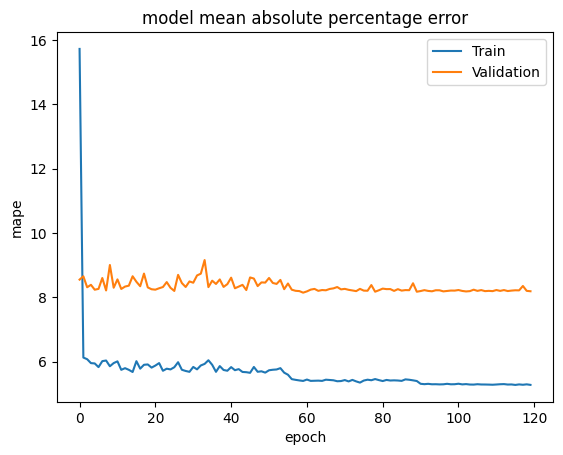

In [32]:
#Plot mape
plt.plot(history.history["mape"], label='Train')
plt.plot(history.history["val_mape"], label='Validation')
plt.legend()
plt.title('model mean absolute percentage error')
plt.ylabel('mape')
plt.xlabel('epoch')
#plt.ylim([35, 150])
#plt.xlim([0, 250])
plt.show

In [ ]:
with open('savedmodels/histories/Multi_input_simplified.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [22]:
model = keras.models.load_model('savedmodels/Multi_input_simplified')

In [23]:
metrics = model.evaluate(testloader.load(), steps=testloader.steps_per_epoch)

print('Metrics: {}'.format(metrics))

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


600/600 [==============================] - 6s 9ms/step - loss: 11.6382 - mape: 7.7199 - mae: 29.8297
Metrics: [11.638222694396973, 7.719865798950195, 29.829673767089844]


In [14]:
#Make trainable
for layer in model.layers:
    layer.trainable = True